# Quantum Random Number Generation

## Using Perceval Library

[Perceval Docs](https://perceval.quandela.net/docs/)

Installation:

In [ ]:
%%capture
!pip install perceval-quandela tqdm

## Boson Sampling

[Perceval Docs](https://perceval.quandela.net/docs/notebooks/Boson%20Sampling.html)

### Importing necessary methods

In [1]:
from IPython import display
from collections import Counter
from tabulate import tabulate
from tqdm.auto import tqdm
import gzip
import pickle
import time

import sympy as sp
import random

import perceval as pcvl
import perceval.lib.symb as symb

#### Defining a function to measure performance

In [4]:
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
import random

def evaluate(data):
    value,counts = np.unique(data, return_counts=True)
    print("Entropy: ", round(entropy(counts, base=None),4))
    
    average = sum(data)/len(data)
    print("Average value: ", round(average,4))
    
    print("Valid output length: ", len(data))
    
    values = [0,0]
    for i in data:
        if i == 0:
            values[0] += 1
        else:
            values[1] += 1
            
    # creating the dataset
    py_rand = [random.randint(0,1) for _ in range(len(data))]
    py_values = [0,0]
    for i in py_rand:
        py_values[i] += 1
    
    X = ['Zeros','Ones']
    X_axis = np.arange(len(X))
    
    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(X_axis - 0.2, values, 0.4, label = 'QRNG')
    plt.bar(X_axis + 0.2, py_values, 0.4, label = 'Python')

    plt.xticks(X_axis, X)
    plt.xlabel("Bit Value")
    plt.ylabel("Count")
    plt.title("Random number distribution")
    plt.legend()
    plt.show()

###  [Perfect Boson sampling](https://perceval.quandela.net/docs/notebooks/Boson%20Sampling.html#Perfect-Boson-sampling)

In [42]:
import itertools

def qrng(bits,modes ,input_mode,backend='CliffordClifford2017'):
    m = modes      #number of modes

    Unitary = pcvl.Matrix.random_unitary(m) #creates a random unitary of dimension m
    
    Sampling_Backend = pcvl.BackendFactory().get_backend(backend)
    
    # Photon modes:
    if input_mode == 1:
        # 1: |1,1,...,1,0,...,0>
        baseState = f'|1{ (m//2 - 1) * ",1"}{ (m//2) * ",0"}>'
    elif input_mode == 2:
        # 2: |15,0,...,0>
        baseState = f'|{ (m * 1) }{ (m-1) * ",0"}>'       # Too Many Zeros
    elif input_mode == 3:
        # 3: |2,2,...2,1,...,1,0,...,0>
        baseState = f'|3{ (m//4 - 1) * ",3"}{ (m//4) * ",2"}{ (m//4) * ",1"}{ (m//4) * ",0"}>'
    elif input_mode == 4:
        # 4: |2,2,...,2,0,...,0>
        baseState = f'|2{ (m // 2 - 1) * ",2" }{ (m // 2) * ",0"}>'
    elif input_mode == 5:
        # 5: |1,1,...,1>
        baseState = f'|1{ (m - 1) * ",1" }>'
    
    s1, s2, s3 = [], [], []
    for _ in range(bits//m + 1):
        s1.append([ i for i in Sampling_Backend(Unitary).sample(pcvl.BasicState(baseState))])
        s2.append([ i for i in Sampling_Backend(Unitary).sample(pcvl.BasicState(baseState))])
        s3.append([ i for i in Sampling_Backend(Unitary).sample(pcvl.BasicState(baseState))])

    s1_raw = list(itertools.chain.from_iterable(s1))
    s2_raw = list(itertools.chain.from_iterable(s2))
    s3_raw = list(itertools.chain.from_iterable(s3))

    s1_normalized = [ 1 if i > 0 else 0 for i in s1_raw[:bits]]
    s2_normalized = [ 1 if i > 0 else 0 for i in s2_raw[:bits]]
    s3_normalized = [ 1 if i > 0 else 0 for i in s3_raw[:bits]]
    
    result = []
    
    for index in range(len(s1_normalized)):
        if s1_normalized[index] > s2_normalized[index]:
            result.append(0)
        elif s2_normalized[index] > s1_normalized[index]:
            result.append(1)
        elif s1_normalized[index] == s2_normalized[index]:
            if s1_normalized[index] == 1 and s3_normalized == 0:
                result.append(0)
            elif s1_normalized[index] == 0 and s3_normalized == 1:
                result.append(1) 
        else:
            pass
    return result

Entropy:  0.6931
Average value:  0.5
Valid output length:  470


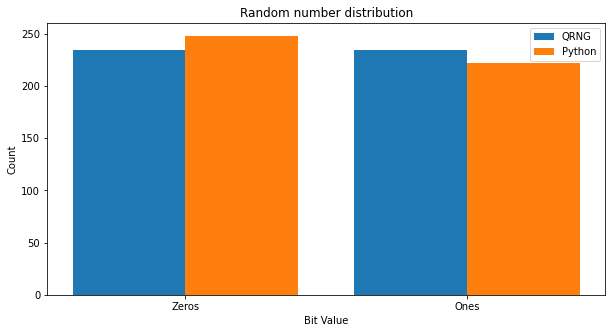

CPU times: user 331 ms, sys: 88.8 ms, total: 420 ms
Wall time: 263 ms


In [48]:
result = qrng(1000,modes=2,input_mode=1)
# result = qrng(1000,modes=2,input_mode=2)
# result = qrng(1000,modes=4,input_mode=3)
# result = qrng(100,modes=2,input_mode=4)
evaluate(result)